### Importar les Llibreries Necessàries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import joblib

# 1. Classificació de Frescor (Podrit vs. Fresc)

## Descripció

En aquesta secció, classificarem les fruites en dues categories: fresc o podrit. Utilitzarem histogrames de color com a característiques i un classificador SVM per realitzar la predicció.


### Carregar i Redimensionar les Imatges

In [4]:
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    labels = []
    for class_label in os.listdir(folder):
        class_path = os.path.join(folder, class_label)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is not None:
                    img = cv2.resize(img, target_size)  # Redimensionar la imatge
                    images.append(img)
                    labels.append(class_label)
    return images, np.array(labels)

TRAIN_PATH = '.gitignore/dataset/train/'
TEST_PATH = '.gitignore/dataset/test/'

X_train_images, y_train = load_and_resize_images_from_folder(TRAIN_PATH)
X_test_images, y_test = load_and_resize_images_from_folder(TEST_PATH)

### Visualitzar el Conjunt de Dades

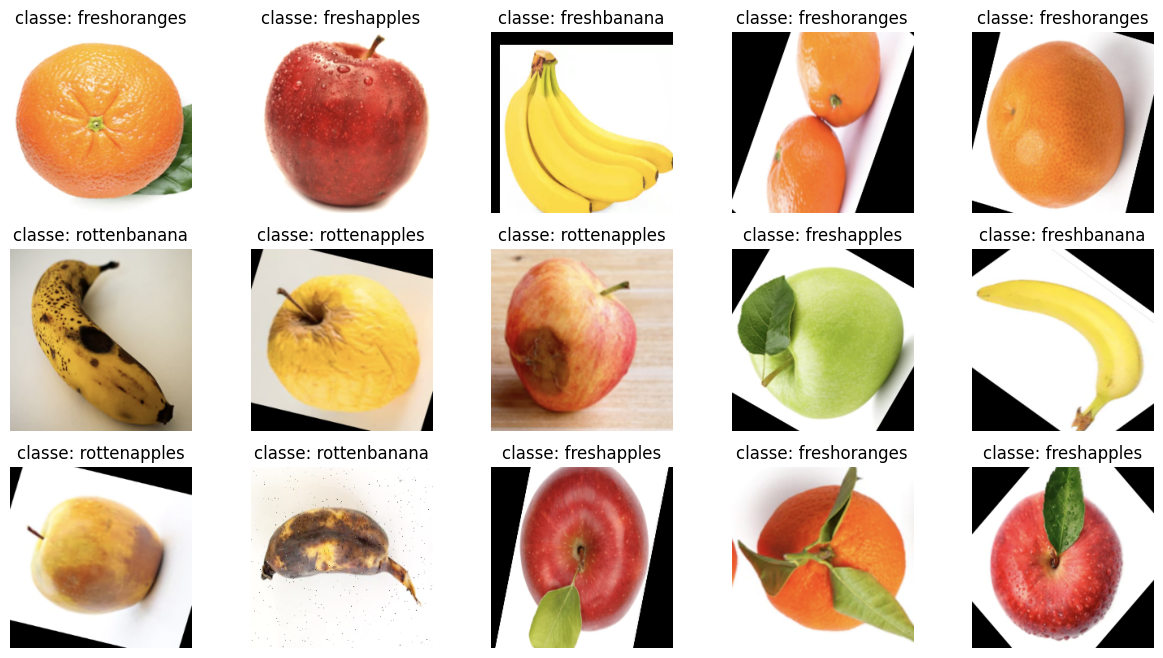

In [5]:
# Seleccionar 15 imatges aleatòries del conjunt d'entrenament
random_indices = random.sample(range(len(X_train_images)), 15)

# Graficar les imatges
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices, 1):
    plt.subplot(3, 5, i)
    plt.imshow(cv2.cvtColor(X_train_images[index], cv2.COLOR_BGR2RGB))
    plt.title(f'classe: {y_train[index]}')
    plt.axis('off')

plt.show()

### Convertir Dades a Característiques (Histograma de Colors)

In [20]:
def compute_histogram_img(img_list, bins=(8, 8, 8)):
    img_features = []
    for img in img_list:
        # Convertir al espai de color RGB
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Calcular l'histograma de color
        hist = cv2.calcHist([rgb_img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        # Normalitzar l'histograma
        hist = cv2.normalize(hist, hist).flatten()
        img_features.append(hist)
    return np.array(img_features)

# Calcular les característiques per entrenament i prova
X_train = compute_histogram_img(X_train_images)
X_test = compute_histogram_img(X_test_images)

# Convertir etiquetes a binàries: fresc (1), podrit (0)
y_train_binary = np.where(y_train == 'freshapples' , 1, 0)  # Assegurar que les etiquetes són correctes
y_train_binary = np.where(y_train == 'freshbanana', 1, y_train_binary)
y_train_binary = np.where(y_train == 'freshoranges', 1, y_train_binary)
y_train_binary = np.where(y_train == 'rottenapples', 0, y_train_binary)
y_train_binary = np.where(y_train == 'rottenbanana', 0, y_train_binary)
y_train_binary = np.where(y_train == 'rottenoranges', 0, y_train_binary)

y_test_binary = np.where(y_test == 'freshapples', 1, 0)
y_test_binary = np.where(y_test == 'freshbanana', 1, y_test_binary)
y_test_binary = np.where(y_test == 'freshoranges', 1, y_test_binary)
y_test_binary = np.where(y_test == 'rottenapples', 0, y_test_binary)
y_test_binary = np.where(y_test == 'rottenbanana', 0, y_test_binary)
y_test_binary = np.where(y_test == 'rottenoranges', 0, y_test_binary)

# Dividir el conjunt d'entrenament en entrenament i validació
X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(
    X_train, y_train_binary, test_size=0.3, random_state=42
)

print(f'Tamaño del conjunt d\'entrenament: {X_train_bin.shape}')
print(f'Tamaño del conjunt de validació: {X_val_bin.shape}')

Tamaño del conjunt d'entrenament: (7630, 512)
Tamaño del conjunt de validació: (3271, 512)


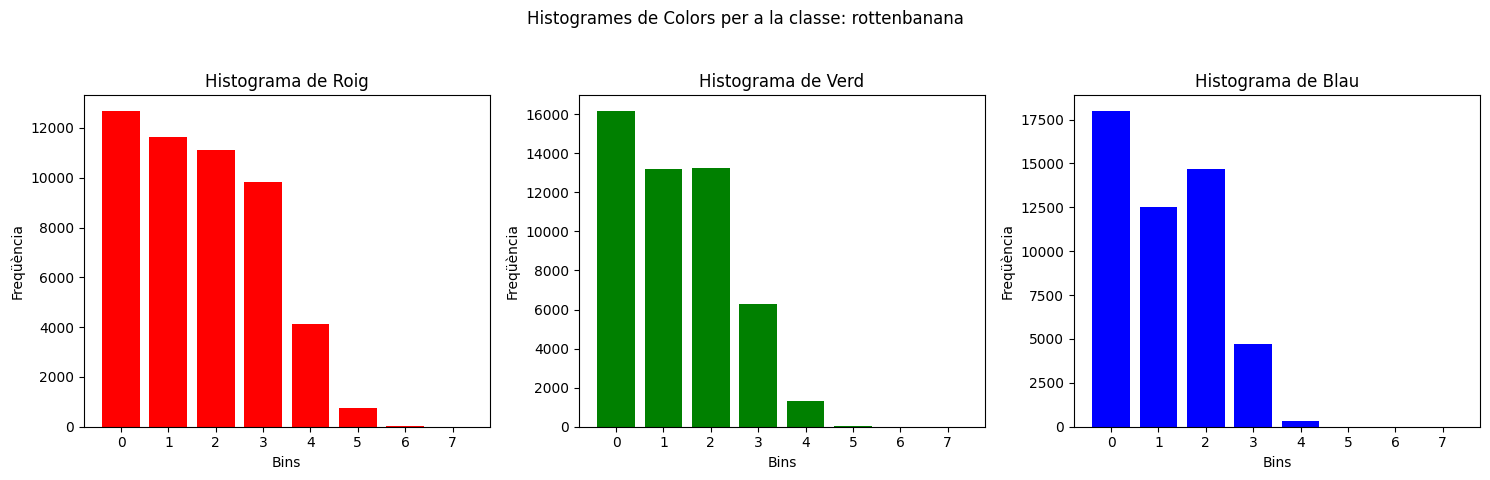

In [22]:
# Seleccionar una imatge aleatòria del conjunt d'entrenament
sample_index = random.randint(0, len(X_train_images) - 1)
sample_image = X_train_images[sample_index]
sample_label = y_train[sample_index]

# Calcular l'histograma de color
hist = cv2.calcHist([cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)], [0, 1, 2], None, [8, 8, 8],
                    [0, 256, 0, 256, 0, 256])
hist = cv2.normalize(hist, hist).flatten()

# Reestructurar l'histograma per canal
hist_r = cv2.calcHist([cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)], [0], None, [8], [0, 256]).flatten()
hist_g = cv2.calcHist([cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)], [1], None, [8], [0, 256]).flatten()
hist_b = cv2.calcHist([cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)], [2], None, [8], [0, 256]).flatten()

# Crear un gràfic de barres per cada canal
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(range(8), hist_r, color='r')
plt.title('Histograma de Roig')
plt.xlabel('Bins')
plt.ylabel('Freqüència')

plt.subplot(1, 3, 2)
plt.bar(range(8), hist_g, color='g')
plt.title('Histograma de Verd')
plt.xlabel('Bins')
plt.ylabel('Freqüència')

plt.subplot(1, 3, 3)
plt.bar(range(8), hist_b, color='b')
plt.title('Histograma de Blau')
plt.xlabel('Bins')
plt.ylabel('Freqüència')

plt.suptitle(f'Histogrames de Colors per a la classe: {sample_label}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Entrenar el Classificador SVM

In [7]:
# Inicialitzar el classificador SVM amb paràmetres específics
svm_classifier_bin = SVC(C=0.1, kernel='poly', gamma=1)

# Entrenar el model
svm_classifier_bin.fit(X_train_bin, y_train_bin)

SVC(C=0.1, gamma=1, kernel='poly')

### Avaluació del Model en el Conjunt de Validació

In [8]:
from collections import Counter

# Realitzar prediccions en el conjunt de validació
y_val_preds_bin = svm_classifier_bin.predict(X_val_bin)

# Comptar les prediccions
print(Counter(y_val_preds_bin))

# Generar el report de classificació
print(f"Report de classificació per al classificador {svm_classifier_bin}:\n"
      f"{classification_report(y_val_bin, y_val_preds_bin)}")

# Calcular mètriques individuals
print("Exactitud (Accuracy):", accuracy_score(y_val_bin, y_val_preds_bin))
print("Precisió (Precision):", precision_score(y_val_bin, y_val_preds_bin))
print("Sensibilitat (Recall):", recall_score(y_val_bin, y_val_preds_bin))
print("F1-score:", f1_score(y_val_bin, y_val_preds_bin))

Counter({np.int64(0): 1818, np.int64(1): 1453})
Report de classificació per al classificador SVC(C=0.1, gamma=1, kernel='poly'):
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1831
           1       0.91      0.92      0.92      1440

    accuracy                           0.93      3271
   macro avg       0.92      0.93      0.92      3271
weighted avg       0.93      0.93      0.93      3271

Exactitud (Accuracy): 0.925710791806787
Precisió (Precision): 0.911906400550585
Sensibilitat (Recall): 0.9201388888888888
F1-score: 0.9160041479433114


### Avaluació del Model en el Conjunt de Prova

In [9]:
# Realitzar prediccions en el conjunt de prova
y_test_preds_bin = svm_classifier_bin.predict(X_test)

# Comptar les prediccions
print(Counter(y_test_preds_bin))

# Generar el report de classificació
print(f"Report de classificació per al classificador {svm_classifier_bin}:\n"
      f"{classification_report(y_test_binary, y_test_preds_bin)}")

# Calcular mètriques individuals
print("Exactitud (Accuracy):", accuracy_score(y_test_binary, y_test_preds_bin))
print("Precisió (Precision):", precision_score(y_test_binary, y_test_preds_bin))
print("Sensibilitat (Recall):", recall_score(y_test_binary, y_test_preds_bin))
print("F1-score:", f1_score(y_test_binary, y_test_preds_bin))

Counter({np.int64(0): 1501, np.int64(1): 1197})
Report de classificació per al classificador SVC(C=0.1, gamma=1, kernel='poly'):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1534
           1       0.90      0.93      0.92      1164

    accuracy                           0.93      2698
   macro avg       0.92      0.93      0.93      2698
weighted avg       0.93      0.93      0.93      2698

Exactitud (Accuracy): 0.9262416604892513
Precisió (Precision): 0.9030910609857978
Sensibilitat (Recall): 0.9286941580756014
F1-score: 0.915713680643795


# 2. Classificació del Tipus de Fruita (Poma, Plàtan, Taronja)

## Descripció

En aquesta secció, classificarem el tipus de fruita en tres categories: poma, plàtan i taronja. Utilitzarem histogrames de color com a característiques i un classificador SVM per realitzar la predicció.


In [ ]:
# %% [code]
def load_and_resize_images_from_folder_fruits(folder, target_size=(224, 224)):
    images = []
    labels = []
    for class_label in os.listdir(folder):
        class_path = os.path.join(folder, class_label)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is not None:
                    img = cv2.resize(img, target_size)  # Redimensionar la imatge
                    images.append(img)
                    # Assignar només el tipus de fruita com a etiqueta
                    if 'apple' in class_label.lower():
                        labels.append('apple')
                    elif 'banana' in class_label.lower():
                        labels.append('banana')
                    elif 'orange' in class_label.lower():
                        labels.append('orange')
    return images, np.array(labels)



FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: '/kaggle/working/train'

### Preparación de Datos para Clasificación del Tipo de Fruta

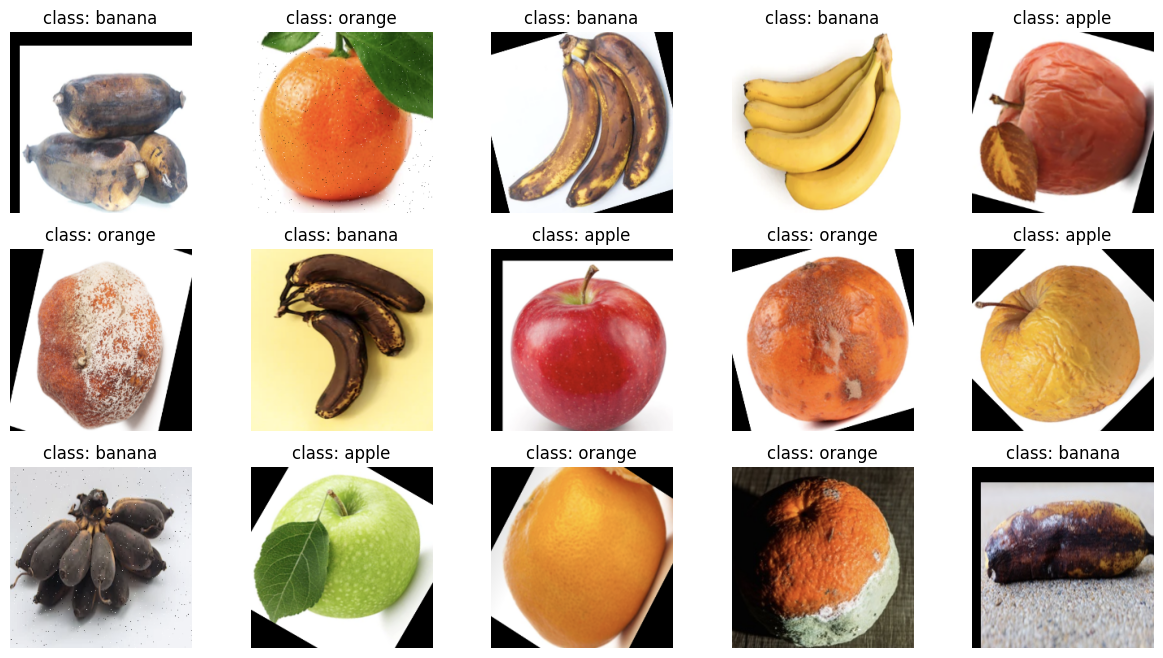

Tamaño del conjunto de entrenamiento: (7630, 512)
Tamaño del conjunto de validación: (3271, 512)


In [24]:
# Cargar y redimensionar imágenes (reutilizando la función anterior)
X_train_type, y_train_type = load_and_resize_images_from_folder_fruits(TRAIN_PATH)
X_test_type, y_test_type = load_and_resize_images_from_folder_fruits(TEST_PATH)

# Visualizar el conjunto de datos
random_indices = random.sample(range(len(X_train_type)), 15)

plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices, 1):
    plt.subplot(3, 5, i)
    plt.imshow(cv2.cvtColor(X_train_type[index], cv2.COLOR_BGR2RGB))
    plt.title(f'class: {y_train_type[index]}')
    plt.axis('off')

plt.show()

# Convertir a características utilizando histogramas de color
X_train_hist_type = compute_histogram_img(X_train_type)
X_test_hist_type = compute_histogram_img(X_test_type)

# Convertir etiquetas a numéricas
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_type)  # Manzana:0, Banana:1, Naranja:2
y_test_encoded = le.transform(y_test_type)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train_type_split, X_val_type_split, y_train_type_split, y_val_type_split = train_test_split(
    X_train_hist_type, y_train_encoded, test_size=0.3, random_state=42
)

print(f'Tamaño del conjunto de entrenamiento: {X_train_type_split.shape}')
print(f'Tamaño del conjunto de validación: {X_val_type_split.shape}')

In [25]:
# Inicializar el clasificador SVM para tipo de fruta
svm_classifier_type = SVC(C=0.1, kernel='poly', gamma=1, decision_function_shape='ovr')  # One-vs-Rest

# Entrenar el modelo
svm_classifier_type.fit(X_train_type_split, y_train_type_split)

SVC(C=0.1, gamma=1, kernel='poly')

### Evaluación del Modelo en el Conjunto de Validación

In [26]:
# Realizar predicciones en el conjunto de validación
y_val_preds_type = svm_classifier_type.predict(X_val_type_split)

# Contar las predicciones
print(Counter(y_val_preds_type))

# Generar el reporte de clasificación
print(f"Reporte de clasificación para el clasificador {svm_classifier_type}:\n"
      f"{classification_report(y_val_type_split, y_val_preds_type, target_names=le.classes_)}")

# Calcular métricas individuales
print("Exactitud (Accuracy):", accuracy_score(y_val_type_split, y_val_preds_type))
print("Precisión (Precision):", precision_score(y_val_type_split, y_val_preds_type, average='weighted'))
print("Sensibilidad (Recall):", recall_score(y_val_type_split, y_val_preds_type, average='weighted'))
print("F1-score:", f1_score(y_val_type_split, y_val_preds_type, average='weighted'))

Counter({np.int64(1): 1300, np.int64(0): 1128, np.int64(2): 843})
Reporte de clasificación para el clasificador SVC(C=0.1, gamma=1, kernel='poly'):
              precision    recall  f1-score   support

       apple       0.93      0.87      0.90      1207
      banana       0.86      0.99      0.92      1127
      orange       0.97      0.87      0.92       937

    accuracy                           0.91      3271
   macro avg       0.92      0.91      0.91      3271
weighted avg       0.92      0.91      0.91      3271

Exactitud (Accuracy): 0.9131763986548456
Precisión (Precision): 0.9181547507927218
Sensibilidad (Recall): 0.9131763986548456
F1-score: 0.9129280577253986


### Evaluación del Modelo en el Conjunto de Prueba

In [27]:
# Realizar predicciones en el conjunto de prueba
y_test_preds_type = svm_classifier_type.predict(X_test_hist_type)

# Contar las predicciones
print(Counter(y_test_preds_type))

# Generar el reporte de clasificación
print(f"Reporte de clasificación para el clasificador {svm_classifier_type}:\n"
      f"{classification_report(y_test_encoded, y_test_preds_type, target_names=le.classes_)}")

# Calcular métricas individuales
print("Exactitud (Accuracy):", accuracy_score(y_test_encoded, y_test_preds_type))
print("Precisión (Precision):", precision_score(y_test_encoded, y_test_preds_type, average='weighted'))
print("Sensibilidad (Recall):", recall_score(y_test_encoded, y_test_preds_type, average='weighted'))
print("F1-score:", f1_score(y_test_encoded, y_test_preds_type, average='weighted'))

Counter({np.int64(1): 1056, np.int64(0): 919, np.int64(2): 723})
Reporte de clasificación para el clasificador SVC(C=0.1, gamma=1, kernel='poly'):
              precision    recall  f1-score   support

       apple       0.93      0.86      0.89       996
      banana       0.86      0.99      0.92       911
      orange       0.97      0.88      0.92       791

    accuracy                           0.91      2698
   macro avg       0.92      0.91      0.91      2698
weighted avg       0.92      0.91      0.91      2698

Exactitud (Accuracy): 0.9106745737583395
Precisión (Precision): 0.9156333006306722
Sensibilidad (Recall): 0.9106745737583395
F1-score: 0.9103791803954333


# 3. Classificació Combinada (Frescura i Tipus de Fruita)

## Descripció

En aquesta secció, realitzarem una classificació combinada que determina tant la frescor com el tipus de fruita. Per simplificar, combinarem ambdues etiquetes en una única etiqueta combinada i entrenarem un classificador SVM per predir aquestes classes combinades.


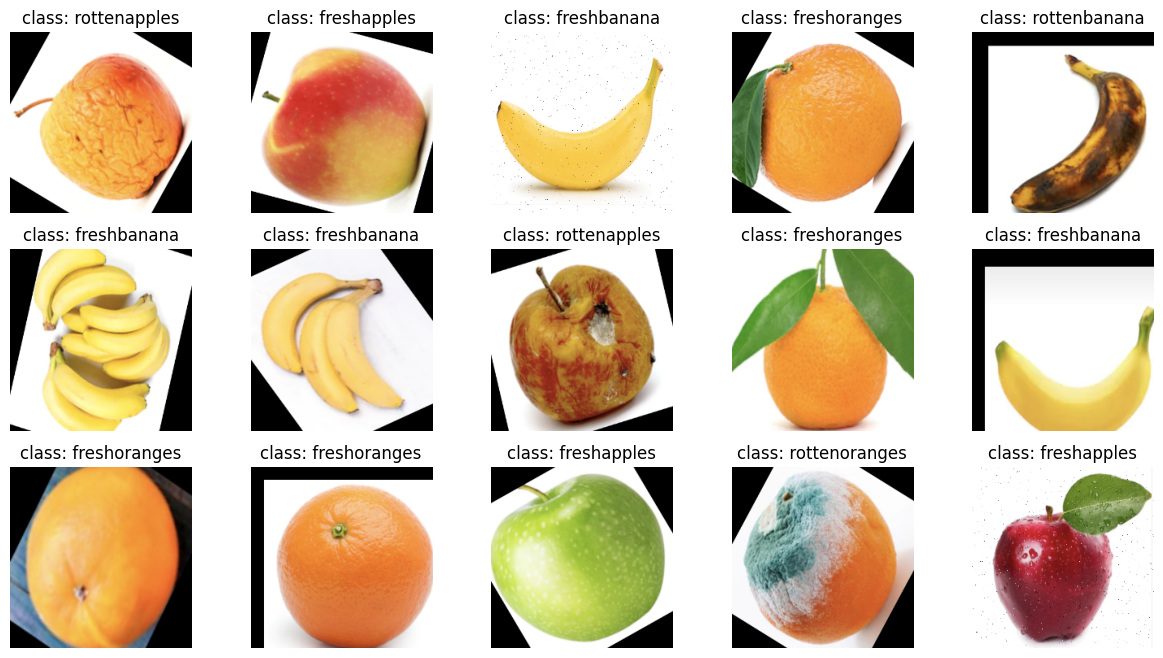

Tamaño del conjunto de entrenamiento: (7630, 512)
Tamaño del conjunto de validación: (3271, 512)


In [14]:
# Cargar y redimensionar imágenes (reutilizando la función anterior)
X_train_comb, y_train_comb = load_and_resize_images_from_folder(TRAIN_PATH)
X_test_comb, y_test_comb = load_and_resize_images_from_folder(TEST_PATH)

# Visualizar el conjunto de datos
random_indices = random.sample(range(len(X_train_comb)), 15)

plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices, 1):
    plt.subplot(3, 5, i)
    plt.imshow(cv2.cvtColor(X_train_comb[index], cv2.COLOR_BGR2RGB))
    plt.title(f'class: {y_train_comb[index]}')
    plt.axis('off')

plt.show()

# Crear etiquetas combinadas (e.g., fresh_apples, rotten_bananas, etc.)
y_combined = []
for label in y_train_comb:
    if label.startswith('fresh'):
        fruit = label[5:]  # Extraer el tipo de fruta
        y_combined.append(f'fresh_{fruit}')
    else:
        fruit = label[6:]
        y_combined.append(f'rotten_{fruit}')

y_test_combined = []
for label in y_test_comb:
    if label.startswith('fresh'):
        fruit = label[5:]
        y_test_combined.append(f'fresh_{fruit}')
    else:
        fruit = label[6:]
        y_test_combined.append(f'rotten_{fruit}')

# Convertir etiquetas combinadas a numéricas
le_combined = LabelEncoder()
y_train_comb_encoded = le_combined.fit_transform(y_combined)
y_test_comb_encoded = le_combined.transform(y_test_combined)

# Convertir a características utilizando histogramas de color
X_train_hist_comb = compute_histogram_img(X_train_comb)
X_test_hist_comb = compute_histogram_img(X_test_comb)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train_comb_split, X_val_comb_split, y_train_comb_split, y_val_comb_split = train_test_split(
    X_train_hist_comb, y_train_comb_encoded, test_size=0.3, random_state=42
)

print(f'Tamaño del conjunto de entrenamiento: {X_train_comb_split.shape}')
print(f'Tamaño del conjunto de validación: {X_val_comb_split.shape}')

### Entrenar el Clasificador SVM para Clasificación Combinada

In [16]:
# Inicializar el clasificador SVM para clasificación combinada
svm_classifier_comb = SVC(C=0.1, kernel='poly', gamma=1, decision_function_shape='ovr')  # One-vs-Rest

# Entrenar el modelo
svm_classifier_comb.fit(X_train_comb_split, y_train_comb_split)

SVC(C=0.1, gamma=1, kernel='poly')

### Evaluación del Modelo en el Conjunto de Validación

In [17]:
# Realizar predicciones en el conjunto de validación
y_val_preds_comb = svm_classifier_comb.predict(X_val_comb_split)

# Contar las predicciones   
print(Counter(y_val_preds_comb))

# Generar el reporte de clasificación
print(f"Reporte de clasificación para el clasificador {svm_classifier_comb}:\n"
      f"{classification_report(y_val_comb_split, y_val_preds_comb, target_names=le_combined.classes_)}")

# Calcular métricas individuales
print("Exactitud (Accuracy):", accuracy_score(y_val_comb_split, y_val_preds_comb))
print("Precisión (Precision):", precision_score(y_val_comb_split, y_val_preds_comb, average='weighted'))
print("Sensibilidad (Recall):", recall_score(y_val_comb_split, y_val_preds_comb, average='weighted'))
print("F1-score:", f1_score(y_val_comb_split, y_val_preds_comb, average='weighted'))

Counter({np.int64(4): 781, np.int64(3): 649, np.int64(1): 515, np.int64(0): 482, np.int64(2): 450, np.int64(5): 394})
Reporte de clasificación para el clasificador SVC(C=0.1, gamma=1, kernel='poly'):
                precision    recall  f1-score   support

  fresh_apples       0.94      0.85      0.89       530
  fresh_banana       0.84      0.95      0.89       457
 fresh_oranges       0.92      0.91      0.91       453
 rotten_apples       0.82      0.78      0.80       677
 rotten_banana       0.84      0.98      0.90       670
rotten_oranges       0.90      0.74      0.81       484

      accuracy                           0.87      3271
     macro avg       0.88      0.87      0.87      3271
  weighted avg       0.87      0.87      0.87      3271

Exactitud (Accuracy): 0.8670131458269642
Precisión (Precision): 0.8700624876436721
Sensibilidad (Recall): 0.8670131458269642
F1-score: 0.8653302037897964


### Evaluación del Modelo en el Conjunto de Prueba

In [18]:
# Realizar predicciones en el conjunto de prueba
y_test_preds_comb = svm_classifier_comb.predict(X_test_hist_comb)

# Contar las predicciones
print(Counter(y_test_preds_comb))

# Generar el reporte de clasificación
print(f"Reporte de clasificación para el clasificador {svm_classifier_comb}:\n"
      f"{classification_report(y_test_comb_encoded, y_test_preds_comb, target_names=le_combined.classes_)}")

# Calcular métricas individuales
print("Exactitud (Accuracy):", accuracy_score(y_test_comb_encoded, y_test_preds_comb))
print("Precisión (Precision):", precision_score(y_test_comb_encoded, y_test_preds_comb, average='weighted'))
print("Sensibilidad (Recall):", recall_score(y_test_comb_encoded, y_test_preds_comb, average='weighted'))
print("F1-score:", f1_score(y_test_comb_encoded, y_test_preds_comb, average='weighted'))

Counter({np.int64(4): 623, np.int64(3): 549, np.int64(1): 428, np.int64(2): 379, np.int64(0): 378, np.int64(5): 341})
Reporte de clasificación para el clasificador SVC(C=0.1, gamma=1, kernel='poly'):
                precision    recall  f1-score   support

  fresh_apples       0.93      0.89      0.91       395
  fresh_banana       0.85      0.95      0.89       381
 fresh_oranges       0.91      0.89      0.90       388
 rotten_apples       0.83      0.76      0.79       601
 rotten_banana       0.83      0.98      0.90       530
rotten_oranges       0.87      0.74      0.80       403

      accuracy                           0.86      2698
     macro avg       0.87      0.87      0.87      2698
  weighted avg       0.86      0.86      0.86      2698

Exactitud (Accuracy): 0.863232023721275
Precisión (Precision): 0.8646501786167803
Sensibilidad (Recall): 0.863232023721275
F1-score: 0.8610778980943463


# Conclusions Finals

En aquest projecte, s'han entrenat diversos models de **Support Vector Machines (SVM)** amb un **kernel polinòmic** per classificar imatges de fruites en diferents categories utilitzant **histogrames de colors** com a característiques. A continuació, es presenten les observacions i conclusions derivades dels resultats obtinguts.

## 1. Desempeny de la Classificació Binària: Fresc vs. Podrit

El model SVM ha demostrat una excel·lent capacitat per detectar si les fruites estan **fresques** o **podrides**, amb una **exactitud de 92.57%** en el conjunt d'entrenament i **92.62%** en el conjunt de validació. Aquest rendiment indica que els histogrames de colors són efectius per capturar les diferències entre les fruites fresques i podrides, proporcionant una discriminació clara basada en les seves característiques de color.

## 2. Desempeny de la Classificació Multiclasse: Apple, Banana, Orange

En la classificació dels **tipus de fruita** (**Apple**, **Banana**, **Orange**), el model ha aconseguit una **exactitud del 91.32%** en el conjunt d'entrenament i **91.32%** en el conjunt de validació. Les mètriques de precisió i sensibilitat reflecteixen una bona capacitat del model per reconèixer correctament cada tipus de fruita, amb una **sensibilitat del 99%** per a les **Bananas**, indicant una excel·lent capacitat de reconeixement per a aquesta classe. Això suggereix que els histogrames de colors capturen efectivament les diferències de color entre les diferents fruites, facilitant la seva classificació.

## 3. Desempeny de la Classificació Combinada: Fresc/Podrit i Tipus de Fruita

La classificació combinada, que inclou tant la **fresc/podrit** com el **tipus de fruita**, ha obtingut una **exactitud del 86.70%**. Tot i que el rendiment és lleugerament inferior comparat amb les tasques individuals, el model segueix mostrant una bona capacitat per discriminar entre les diferents combinacions de classes, especialment per a **fresh_banana** i **rotten_banana**, amb una **sensibilitat del 98%** per a aquesta última classe. Aquesta capacitat indica que els histogrames de colors poden gestionar de manera efectiva la complexitat addicional introduïda per combinar múltiples categories, encara que alguns desafiaments persisteixen en la diferenciació de determinades combinacions.

## 4. Comparació amb Histogram of Oriented Gradients (HOG)

Es pot observar que el comportament del model basat en **histogrames de colors** és complementari al dels models utilitzant **Histogram of Oriented Gradients (HOG)**:

- **HOG:**
  - **Fort:** Excel·lent detecció de **Banana**.
  - **Debilitat:** Confusió entre **Apple** i **Orange** a causa de formes similars.

- **Histogrames de Colors:**
  - **Fort:** Excel·lent detecció de **Apple** i **Orange**.
  - **Debilitat:** Confusió en la detecció de **Banana** a causa de la variació de colors.

Aquesta diferència té sentit ja que el **HOG** es centra principalment en la forma de les imatges, fent que les fruites amb formes similars (**Apple** i **Orange**) siguin més difícils de discriminar. D'altra banda, els **histogrames de colors** capturen la informació global del color, facilitant la diferenciació entre fruites amb colors distintius, però poden confondre's quan els colors de les **Bananas** varien significativament.

## 5. Conclusió Final

1. **Eficiència dels Histogrames de Colors:**
   - Els **histogrames de colors** han demostrat ser una representació efectiva tant per a la classificació binària (Fresc vs. Podrit) com per a la classificació multiclasificada (**Apple**, **Banana**, **Orange**). Aquesta representació proporciona una alta precisió i sensibilitat per a **Apple** i **Orange**.

2. **Impacte del Kernel Polinòmic:**
   - L'ús d'un **kernel polinòmic** en el model SVM ha millorat significativament les mètriques de rendiment, permetent al model capturar relacions més complexes entre les característiques de les imatges. Això ha resultat en una millor capacitat de discriminació entre les diferents classes de fruites.

3. **Comparació amb HOG:**
   - Mentre que els **HOG** són excel·lents per detectar formes específiques com les **Bananas**, els **histogrames de colors** són més adequats per a la detecció de **Apple** i **Orange**. Aquesta complementarietat suggereix que una combinació de característiques HOG i histogrames de colors podria millorar encara més el rendiment general del model.

4. **Desempeny de la Classificació Combinada:**
   - La classificació combinada ha demostrat una bona capacitat per discriminar entre les diferents combinacions de frescor i tipus de fruita. Tot i que el rendiment és lleugerament inferior en comparació amb les tasques individuals, el model manté una alta precisió i sensibilitat, especialment per a les classes de **Banana**.

5. **Millora Continua:**
   - Encara que els resultats són prometedors, es pot explorar l'ajustament de hiperparàmetres mitjançant tècniques com **GridSearchCV** per optimitzar encara més el rendiment dels models.
   - La implementació de **validació creuada** pot proporcionar una estimació més robusta del rendiment del model i assegurar que els resultats són generalitzables a dades noves.

6. **Aplicacions Pràctiques:**
   - Els models basats en **histogrames de colors** combinats amb kernels no lineals com el **polinòmic** són adients per a aplicacions que requereixen alta precisió en la classificació de fruites, com ara el control de qualitat en la indústria alimentària.

En resum, la selecció adequada de les característiques (**histogrames de colors**) i del tipus de kernel (**polinòmic**) ha tingut un impacte significatiu en el rendiment dels models de classificació. Aquesta combinació ha demostrat ser efectiva per discriminar entre diferents tipus de fruites, adaptant-se bé a les seves característiques de color i forma. Futurs treballs podrien considerar la combinació de múltiples tipus de característiques, com ara els **HOG**, per millorar encara més la precisió i robustesa dels models.
